# クラスタリング(clustering)
データをいくつかのクラスタにグループ分けをする**クラスタリング**についてまとめる。

データ$D = \left\{d^{1}, d^{2}, \cdots, d^{n}\right\}$が与えられ、$D$内の各要素はそれぞれベクトル$d^{1} = \left(x_{1}, x_{2}, \dots, x_{n}\right)$で表現されているとする。

---
# クラスタ間の類似度

### 距離関数
クラスタ間の類似度を測るために二つのベクトル$x_{i}$と$x_{j}$の間の距離を定義する必要がある。

 - $d$: 各ベクトルの次元数
 - $x_{i} = {\left({x}_{i1}, \dots ,{x}_{id}\right)}^{T}$

**ユークリッド距離**
$$
d\left(x_{i}, x_{j}\right) = {\left[\sum _{k=1}^{d}{{\left({x}_{ik} - {x}_{jk}\right)}^{2}} \right]}^{1/2}
$$

**方向余弦**
ベクトル間の角度($\cos {\theta}$)を用いた尺度であり、よく利用される。
$$
d\left(x_{i}, _{j}\right) = \frac { \sum _{k=1}^{d}{{x}_{ik}{x}_{jk}} }{  \sqrt {\left(\sum _{k=1}^{d}{{{x}_{ik}}^{2}}\right)\left(\sum _{k=1}^{d}{{{x}_{jk}}^{2}}\right)} }
$$

In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# データセットの読み込み
ここでは、企業が従業員の離職を減少させるために人事部が離職要因の特定と各従業員の離職確率の予測精度向上を目標としているとする。

人事部の達成目標
 - 離職要因の特定
 - 各従業員の離職予測

In [3]:
HR_DATASET_PATH = "../datasets/HR_comma_sep.csv"

hr_df = pd.read_csv(HR_DATASET_PATH)
hr_df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [4]:
print(len(hr_df.index))
print(hr_df.isnull().values.sum())

14999
0


欠損している行はない。

In [5]:
hr_df.sales.unique()

array(['sales', 'accounting', 'hr', 'technical', 'support', 'management',
       'IT', 'product_mng', 'marketing', 'RandD'], dtype=object)

In [6]:
hr_df.salary.unique()

array(['low', 'medium', 'high'], dtype=object)

In [7]:
# salary(給与水準)をダミー変数へ置換する
hr_df.salary.replace({'low': 1, 'medium': 2, 'high': 3}, inplace=True)

---
# 凝集(ぎょうしゅう)型クラスタリング(agglomerative clustering)
「単純に最も似ているもの同士をくっつけていけばいい」というクラスタリング方法。別名「ボトムアップクラスタリング」

## 凝集型クラスタリングのアルゴリズム
(ただし、$sim$は二つのクラスタの類似度を表す)

$
入力: 特徴ベクトル集合D = \left\{x^{1}, x^{2}, \cdots, x^{\left| D \right|}\right\}\\
C = \left\{c_{1}, c_{2}, \cdots, c_{\left| D \right|}\right\}\\
＃ １つのクラスタに１つの特徴ベクトルを割り当てる\\
c_{1} = \left\{x^{1}\right\}, c_{2} = \left\{x^{2}\right\}, \cdots, c_{\left| D \right|} = \left\{x^{\left| D \right|}\right\}\\
while \left| C \right| \ge 2 \quad ＃ 反復条件\\
\quad ＃ 最も似ているクラスタ対をみつける\\
\quad \left(c_{m}, c_{n}\right) = arg \quad \max _{ c_{i},c_{j} \in C }{ sim\left(c_{i}, c_{j}\right) } \\
\quad ＃ みつかったクラスタ対を融合する\\
\quad marge \left(c_{m}, c_{n}\right)\\
end　while
$

はじめは、似ている特徴ベクトル同士を融合するのだが、クラスタリングが進むに従って、似ているクラスタと特徴ベクトル、あるいは似ているクラスタ同士を、融合することになる。ベクトル同士の場合はそれぞれの特徴ベクトルの余弦類似度を測って、最も似ているクラスタ同士をみつければよい。しかし、一般にクラスタ同士の場合、つまり片方または両方が一つのベクトルではなく複数のベクトルからなる場合、そのように計算したらよいかは自明ではない。つまり、一般にクラスタ同士の類似度が定義されている必要がある。

## クラスタ同士の類似度を測る
ベクトル同士$\left(d_{k}, d_{l}\right)$の類似度$sim\left(d_{k}, d_{l}\right)$は定義されているとする。

### 単連結法(single-linkage method)
二つのクラスタが与えられたとき、その中で最も近い特徴ベクトル対の類似度を、その二つのクラスタ類似度とする方法
$$
sim\left(c_{i}, c_{j} \right) = \max _{x_{k} \in c_{i}, x_{l} \in c_{j}}{d\left(x_{k}, x_{l}\right)}
$$
この値が最も大きなクラスタ対が最も似ているクラスタであるので、アルゴリズムのもっとも似ているクラスタ対をみつける段階では、
$$
\left( c_{ m },c_{ n } \right) =arg{ \max _{ c_{ i },c_{ j }\in C }{ \max _{ { x }_{ k }\in { c }_{ i },{ x }_{ l }\in { c }_{ j } }{ d\left( { x }_{ k },{ x }_{ l } \right)  }  }  }
$$
を計算することになる。
 
 - クラスタに一つデータが追加されると、他のクラスタとの距離は小さくなるか、または変化しない
 - 大きなクラスタができる傾向がある  
 - 近いデータが別なクラスタに属する**連鎖効果**が現れる場合がある


### 完全連結法(complete-linkage method)
 これは、二つのクラスタが与えられたとき、その中で最も遠い特徴ベクトル同士の類似度を、その二つのクラスタの類似度とする方法
 $$
 sim\left( c_{ i },c_{ j } \right) =\max _{ x_{ k }\in c_{ i },x_{ l }\in c_{ j } }{ d\left( x_{ k },x_{ l } \right)  } 
 $$
 
  - クラスタに一つデータが追加されると、ほかのクラスタとの距離は大きくなるか、または変化しない
  - 大きなクラスタになりにくく、同じようなサイズのクラスタができる傾向がある
  - 連鎖効果は現れない


### 群平均法(group-average method)
二つのクラスタが与えられたとき、クラスタ内の**すべてのデータ対間の距離の平均**でクラスタ間の距離を決める方法
$$
sim\left(c_{i}, c_{j}\right) = \frac {1}{ N_{c_{i}}N_{c_{j}} } \sum _{x_{k} \in c_{i}, x_{l} \in c_{j}}{ d\left( x_{ k },x_{ l } \right) }
$$


### ウォード法(Ward method)
ウォード法は二つのクラスタの距離を、それらを融合したときに**クラスタ内変動の増加分**
$$
sim\left(c_{i}, c_{j}\right) = \sum _{ x \in c_{i},c_{j} }{ {d\left(x, {\mu}_{c_{i}c_{j}}\right)}^{2} } - \left( \sum _{ x \in c_{i} }{ {d\left(x, {\mu}_{c_{i}}\right)}^{2} } + \sum _{ x \in c_{j} }{ {d\left(x, {\mu}_{c_{j}}\right)}^{2} } \right)\\
= S_{c_{ij}} - \left(S_{c_{i}} + S_{c_{j}}\right)
$$
で定義し、距離の小さなクラスタから融合していく方法である。ウォード法はクラスタ内変動の増加分で距離を定義しているので、階層法の中で**もっとも精度が高い**方法である。
 - $d\left(x_{k}, x_{l}\right)$: ユークリッド距離
 - ${\mu}_{c_{i}c_{j}}$: クラスタ$c_{i}$と${c}_{j}$を融合したクラスタの平均ベクトル
 - ${\mu}_{c_{i}}, {\mu}_{c_{j}}$: クラスタ$c_{i}$と${c}_{j}$それぞれの平均ベクトル
 - $S$: 平均からの偏差の2乗和
 


### 重心法(centroid method)
各クラスタは、それが含む特徴ベクトルの**重心ベクトル(centroid)**により代表されているとしよう。重心法では、与えられた二つのクラスタに対し、それらの重心間の類似度をこれらのクラスタ間の類似度とする。
$$
sim\left( c_{ i },c_{ j } \right) =d\left( \frac { 1 }{ \left| { c }_{ i } \right|  } \underset { x\in { c }_{ i } }{ \sum { x }  } ,\frac { 1 }{ \left| { c }_{ j } \right|  } \underset { x\in { c }_{ j } }{ \sum { x }  }  \right) 
$$

## 凝集型クラスタリングの実行
離職者を凝集型クラスタリグを行うことでグループに分けて、それぞれの離職要因を特定する。

In [8]:
left_employee_df = hr_df[hr_df['left'] == 1]

In [9]:
left_employee_df.shape

(3571, 10)

/Users/taiyou/.pyenv/versions/anaconda3-2.3.0/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


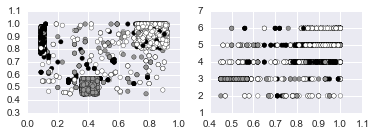

In [10]:
from sklearn.cluster import AgglomerativeClustering

X = left_employee_df.drop(['left', 'sales'], axis=1)

# 凝集型クラスタクラスの生成
# http://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html
ac = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward', compute_full_tree=True)
ac_model = ac.fit(X)
labels = ac_model.labels_

# scater method → http://pythondatascience.plavox.info/matplotlib/%E6%95%A3%E5%B8%83%E5%9B%B3
# 画面を縦2つ、横1つに分割したときの、1番目の ax に移動
ax1 = plt.subplot(221)
ax2 = plt.subplot(222)

ax1.scatter(X['satisfaction_level'], X['last_evaluation'], c=labels)
ax2.scatter(X['last_evaluation'], X['time_spend_company'], c=labels)
plt.show()

クラスタリングの結果がわかりにくい。

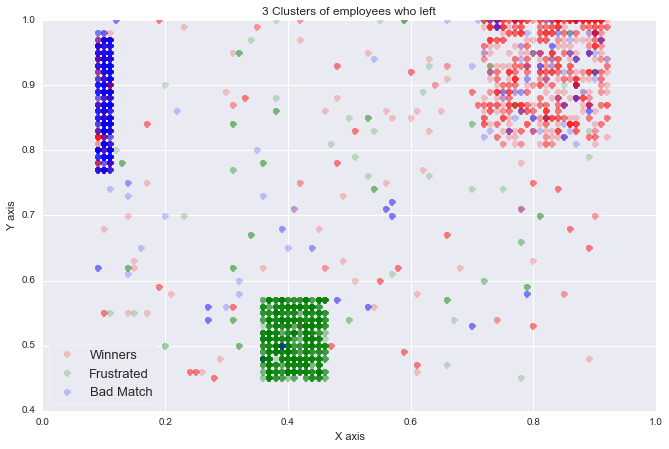

In [12]:
X['label'] = ac_model.labels_

plt.figure(figsize=(11,7))
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.title('3 Clusters of employees who left')

plt.plot(X.satisfaction_level[X.label==0], X.last_evaluation[X.label==0],'o', alpha = 0.2, color = 'r')
plt.plot(X.satisfaction_level[X.label==1], X.last_evaluation[X.label==1],'o', alpha = 0.2, color = 'g')
plt.plot(X.satisfaction_level[X.label==2],X.last_evaluation[X.label==2],'o', alpha = 0.2, color = 'b')
plt.legend(['Winners','Frustrated','Bad Match'], loc = 'best', fontsize = 13, frameon=True)

plt.show()

### 樹形図(dendrogram)の描画

/Users/taiyou/.pyenv/versions/anaconda3-2.3.0/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


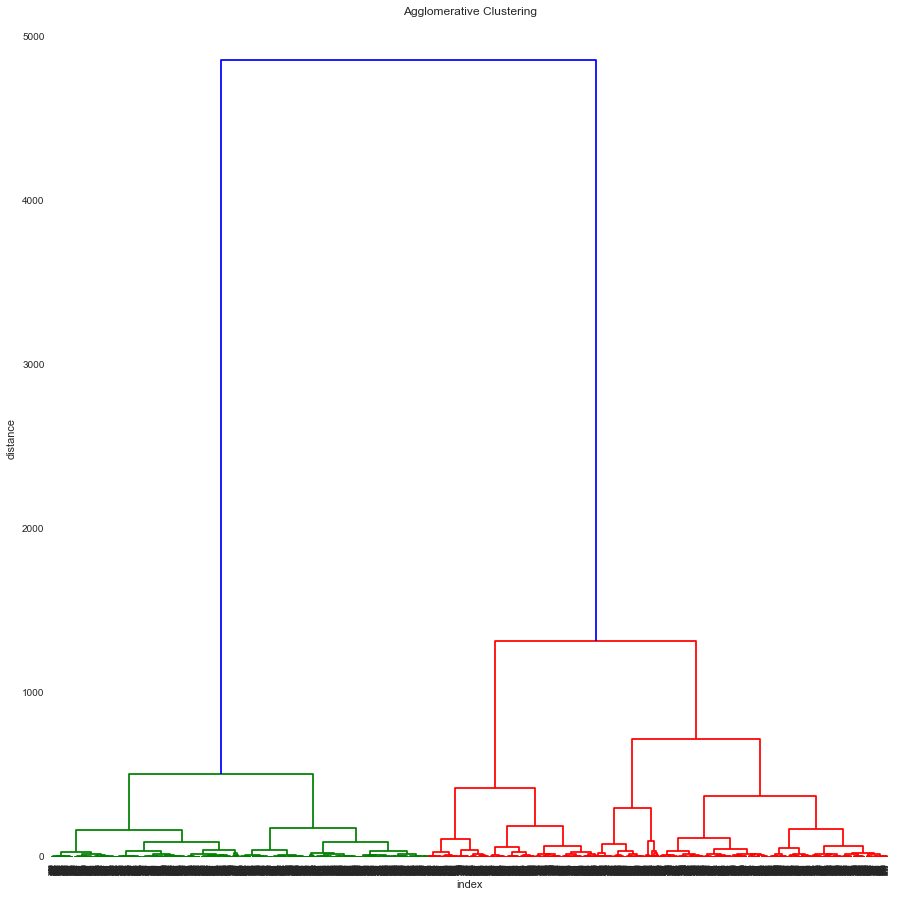

In [13]:
from scipy.cluster.hierarchy import linkage, dendrogram

X = left_employee_df.drop(['left', 'sales'], axis=1).as_matrix()

# https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html
Z = linkage(X, method='ward', metric='euclidean')

plt.subplots(figsize=(15, 15))
plt.title('Agglomerative Clustering')
plt.xlabel('index')
plt.ylabel('distance')
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html
dendrogram(Z, orientation="top");
plt.show()